# Simulating single DSA-200 Image (DAT-like output)

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or as Vivana did it:

`python sky_model.py  --agn /safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_AGNs_complete_wide.fits --sfg "/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide1.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide2.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide3.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide4.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide5.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide6.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide7.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide8.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide9.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide10.fits" -o /safepool/vrosero/TRECs/images/dsa2k_first+trecsagnsfg_8192.fits  --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [1]:
import os.path
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [2]:
from data import fits_image
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

## Create image

In [3]:
#!cd /home/claw/code/tyrones_stuff

In [4]:
#!python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits -o /fastpool/claw/images/test.fits --npix 1024  --target 0 0 0.25 0.25

In [5]:
#input_image = '/fastpool/claw/images/test.fits'
#image, imwcs = fits_image(input_image)
#print(image.std(), image.min(), image.max())
#plot_image(image, vmin=image.min(), vmax=image.max())

In [6]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [7]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [8]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [9]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[0]-size//2):(center[0]+size//2), (center[1]-size//2):(center[1]+size//2)]*pb_kernel)

## 1. Read image

In [14]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/fastpool/claw/images/test.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero.fits'
pixscale = 1*3600/8192  # image px size in arcsec (4 deg and 8192 pixels on a side)

In [15]:
image, imwcs = fits_image(input_image)

In [16]:
IMAGE_SIZE = image.shape[0]
CPU_COUNT = 2
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE}. Pixel scale: {pixscale}"')

Image size: 8196. Pixel scale: 0.439453125"


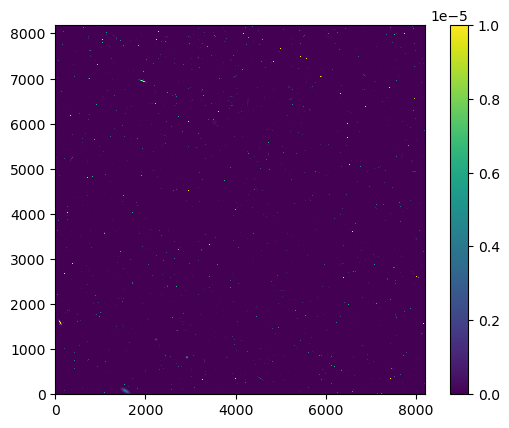

In [17]:
im = fits.open(input_image)[0].data.squeeze()
plot_image(im, vmin=im.min(), vmax=0.00001)

## 2. Add noise

In [18]:
noise_sigma = 6e-8   # gives roughly 2 microJy/beam noise in empty sky
realbeam = False
bmaj = 3.3 #arcsec

if realbeam:
    psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
    psf_image, psf_wcs = fits_image(psf_filename)

    # normalization factor for core of PSF that overlaps input image
#    psf_width = psf_image.squeeze().shape[0]
#    psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
#                                   psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

#    print(psf_norm, psf_width, IMAGE_SIZE)
else:
    # overload with restoring beam
#    pixscale_psf = imwcs.to_header()['CDELT2']*u.deg.to('arcsec')    # PSF px size in arcsec
    pixscale = imwcs.to_header()['CDELT2']*u.deg.to('arcsec')
    sig = bmaj/pixscale/2.355  #2.35 = 2*sqrt(2*ln(2))
    psf_image = gkern(l=64, sig=sig)
#    psf_norm = psf_image.sum()

In [19]:
hdu = fits.open(input_image)[0]
image = np.ma.masked_invalid(hdu.data.squeeze())
image.set_fill_value(0)
hdr = hdu.header
noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
noise_convolved = convolve(noise, psf_image, mode="same", method="fft")

hdr['BUNIT'] = 'Jy/beam'
hdr['BTYPE'] = 'Intensity'
hdr['BMAJ'] = bmaj*u.arcsec.to(u.deg)
hdr['BMIN'] = bmaj*u.arcsec.to(u.deg)
hdr['BPA'] = 0.0

print(noise_convolved.std())

3.4772387e-07


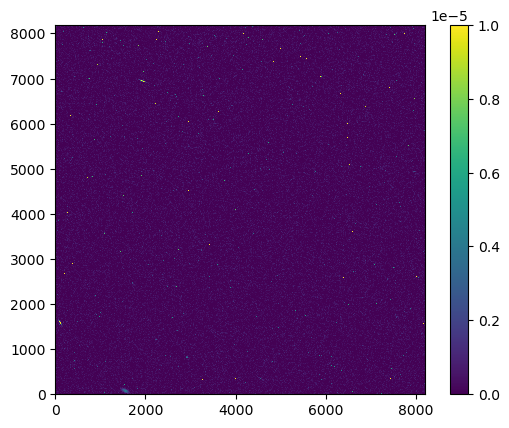

In [20]:
image_noise = image.filled()+np.array(noise_convolved)
plot_image(image_noise, vmax=1e-5)

## 3. Convolve image with PSF 

In [21]:
# note that noise is double convolved
image_convolved = convolve(image_noise, psf_image, mode="same", method="fft")

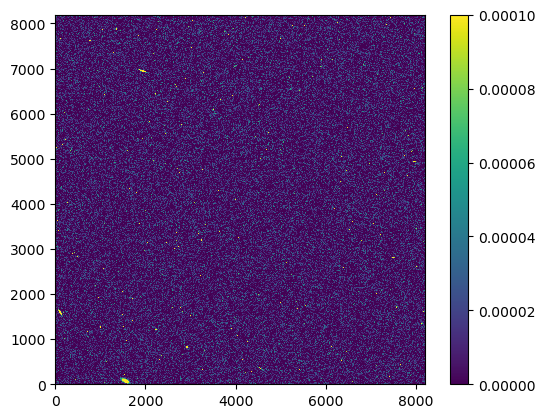

In [22]:
plot_image(image_convolved, vmax=1e-4)

In [23]:
if realbeam:
    fits.writeto(input_image.replace('.fits', 'noiseconv.fits'), image_convolved, header=hdr, overwrite=True)
else:
    fits.writeto(input_image.replace('.fits', 'noiserestored.fits'), image_convolved, header=hdr, overwrite=True)

## Catalog of sky model

In [24]:
cd ../../tyrones_stuff/

/home/claw/code/tyrones_stuff


/home/claw/.conda/envs/py310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
import catalog_utils
tbf, tbs, tba = catalog_utils.mask([[-0.5*u.deg, -0.5*u.deg], [0.5*u.deg, 0.5*u.deg]],
                                   # [[0*u.deg, 0*u.deg], [0.25*u.deg, 0.25*u.deg]],
                                   first=catalog_utils.get_srcs('/fastpool/claw/catalogs/first/first_14dec17.fits', 'first'),
                                   sfg=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_SFGs_complete_5sqdeg.fits', 'trecs-sfg'),
                                   agn=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_AGNs_complete_5sqdeg.fits', 'trecs-agn'))

In [26]:
#sfg
dfs = tbs[['I1350', 'longitude', 'latitude']].to_pandas()
s = tbs
ecc = np.sqrt(s["e1"].value**2 + s["e2"].value**2)  # eccentricity                                                               
major = 1 / (1 - ecc) * s["size"].value
minor = 1 / (1 + ecc) * s["size"].value
rot = np.arctan2(s["e1"].value, s["e2"].value)  # position angle
dfs.insert(3, 'major', major)
dfs.insert(4, 'minor', minor)
dfs.insert(5, 'posang', rot)
dfs.insert(6, 'source', len(dfs)*['sfg'])
dfs.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#agn
s = tba
major = np.cast[float](tba['size'])
rs = np.cast[float](tba['Rs'])
minor = major * np.cast[float](rs)
posang = np.zeros_like(major)
dfa = tba[['I1350', 'longitude', 'latitude']].to_pandas()
dfa.insert(3, 'major', major)
dfa.insert(4, 'minor', minor)
dfa.insert(5, 'posang', posang)
dfa.insert(6, 'source', len(dfa)*['agn'])
dfa.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#first
dff = tbf[['FPEAK', 'RA', 'DEC', 'FITTED_MAJOR', 'FITTED_MINOR', 'POSANG']].to_pandas()
dff.insert(6, 'source', len(dff)*['first'])
dff.rename(columns={'FITTED_MAJOR': 'major', 'FITTED_MINOR': 'minor', 'POSANG': 'posang'}, inplace=True)

In [27]:
df = pd.concat([dfs, dfa, dff])

In [28]:
df

,FPEAK,RA,DEC,major,minor,posang,source
0,0.085829,-1.055189,0.242807,15.067787,12.929529,1.510294,sfg
1,0.041819,0.061436,0.043855,11.014426,7.838243,0.809732,sfg
2,0.267183,-1.374586,0.166812,23.696939,7.509079,-1.886805,sfg
3,0.265321,-1.042675,0.173539,21.280716,7.394516,-1.776368,sfg
4,0.016437,-0.286320,-0.400658,4.813237,4.595062,0.482773,sfg
...,...,...,...,...,...,...,...
81,1.020000,359.614392,-0.428686,7.490000,5.930000,149.300003,first
82,3.850000,359.719108,-0.457642,6.090000,5.120000,59.900002,first
83,0.950000,359.746375,-0.467125,5.360000,3.680000,30.100000,first
84,2.480000,0.047012,-0.470247,6.490000,5.200000,22.200001,first


In [29]:
from astropy import coordinates
coordinates.SkyCoord(dfs.sort_values('FPEAK')[['RA', 'DEC']].to_numpy(), unit='deg')[-10:].to_string('hmsdms')

['23h52m07.88214684s +00d18m16.74721956s',
 '23h58m49.45161581s +00d26m17.63156891s',
 '00h01m32.37210274s +00d21m49.11841393s',
 '23h56m31.45538807s +00d04m53.46874952s',
 '23h51m41.12440109s -00d09m43.25761557s',
 '23h52m07.11885452s +00d26m24.08635855s',
 '23h56m02.13406563s -00d05m04.69679832s',
 '23h52m33.38627815s +00d02m27.56831378s',
 '23h58m21.92980528s -00d25m00.01198053s',
 '23h55m47.52639771s -00d17m20.8932209s']

In [30]:
df.to_csv(input_image.replace('.fits', 'catalog.csv'))